# core

> SOM class implementation

In [ ]:
#| default_exp core

In [ ]:
#| export
import numpy as np
from sklearn.decomposition import PCA
from fastcore.all import *
import matplotlib.pyplot as plt
from fastprogress.fastprogress import progress_bar, master_bar
from IPython.display import display, HTML, clear_output

In [ ]:
#| exports
dist_fn = lambda x, ws: np.linalg.norm(ws-x, axis=-1)

In [ ]:
#| exports
class SOM:
    def __init__(self, 
                 grid_sz:tuple, # grid size
                 input_dim:int, # input dimension
                 init:str='random', # initialization method
                #  dist_fn=np.linalg.norm # distance function
                 dist_fn=dist_fn # distance function
                 )->None: # initialize the SOM
        "Initialize a Self-Organizing Map with given grid size and input dimension"
        store_attr()
        self.weights = None  # Will be initialized when fitting

In [ ]:
#| exports
@patch
def _initialize_weights_pca(self:SOM, X:np.ndarray)->np.ndarray:
    "Initialize weights using PCA of the input data"
    pca = PCA(n_components=2)
    pca.fit(X)
    
    # Create grid coordinates and scale by eigenvalues
    n = self.grid_sz[0]
    alpha = np.linspace(-1, 1, n) * np.sqrt(pca.explained_variance_[0])
    beta = np.linspace(-1, 1, n) * np.sqrt(pca.explained_variance_[1])
    
    # Create the grid
    alpha_grid, beta_grid = np.meshgrid(alpha, beta)
    
    # Initialize weights as linear combination of first two PCs
    return (alpha_grid[..., np.newaxis] * pca.components_[0] + 
            beta_grid[..., np.newaxis] * pca.components_[1])

In [ ]:
#| exports
@patch
def _initialize_weights(self:SOM, 
                        X:np.ndarray=None, # data matrix
                        method:str='random' # initialization method
                        )->np.ndarray: # weights matrix
    "Initialize weights using either random or PCA initialization"
    if method == 'random':
        return np.random.randn(*self.grid_sz, self.input_dim)
    elif method == 'pca':
        if X is None: 
            raise ValueError("Data matrix X required for PCA initialization")
        return self._initialize_weights_pca(X)

In [ ]:
#| exports
@patch
def _find_bmu(self:SOM, 
              x:np.ndarray, # input vector
              )->tuple: # coordinates of the best matching unit
    "Find coordinates of Best Matching Unit for input x"
    distances = self.dist_fn(x, self.weights)
    return np.unravel_index(np.argmin(distances), self.grid_sz)

In [ ]:
#| exports
@patch
def _grid_distances(self:SOM, 
                    bmu_pos:tuple # coordinates of the best matching unit
                    )->np.ndarray: # grid distances
    "Calculate grid distances from BMU position"
    rows_idx, cols_idx = np.ogrid[0:self.grid_sz[0], 0:self.grid_sz[1]]
    return (bmu_pos[0] - rows_idx)**2 + (bmu_pos[1] - cols_idx)**2

In [ ]:
#| exports
@patch
def _neighborhood_function(self:SOM, 
                           grid_dist:np.ndarray, # grid distances
                           sigma:float # neighborhood radius
                           )->np.ndarray: # neighborhood function values
    "Calculate neighborhood function values"
    return np.exp(-grid_dist/(2*sigma**2))

In [ ]:
#| exports
@patch
def _update_weights(self:SOM, 
                    x:np.ndarray, # input vector
                    learning_rate:float, # learning rate
                    sigma:float # neighborhood radius
                    )->None: # update weights
    "Update weights for a single input vector"
    bmu_pos = self._find_bmu(x)
    grid_dist = self._grid_distances(bmu_pos)
    neighborhood = self._neighborhood_function(grid_dist, sigma)
    self.weights += learning_rate * neighborhood[..., np.newaxis] * (x - self.weights)

In [ ]:
#| exports
def exp_sched(start_val, end_val, i, n_steps):
    decay = -np.log(end_val/start_val)/n_steps
    return start_val * np.exp(-decay * i)

In [ ]:
#| exports
class Scheduler:
    def __init__(self, start_val, end_val, step_size, 
                 n_samples, n_epochs, decay_fn=exp_sched):
        store_attr()
        self.current_step = 0
        self.current_value = start_val
        self.total_steps = (n_samples * n_epochs) // step_size
    
    def step(self, total_samples):
        if total_samples % self.step_size == 0:
            self.current_value = self.decay_fn(
                self.start_val, self.end_val, 
                self.current_step, self.total_steps
            )
            self.current_step += 1
        return self.current_value

In [ ]:
#| exports
def format_metrics_html(
    epochs_data:list, # list of tuples: [(epoch, qe, te), ...]
    ):
    # Format the metrics as an HTML table
    # epochs_data should be a list of tuples: [(epoch, qe, te), ...]
    rows = ''.join([
        f"""
            <tr>
                <td style="padding: 3px">{epoch+1:3d}</td>
                <td style="padding: 3px">{qe:8.4f}</td>
                <td style="padding: 3px">{te:8.4f}</td>
            </tr>
        """ for epoch, qe, te in epochs_data
    ])
    
    return f"""
    <div style="font-family: monospace; margin: 10px">
        <h4>Training Progress</h4>
        <table style="border-collapse: collapse">
            <tr style="border-bottom: 2px solid #ddd">
                <th style="font-weight: bold; padding: 5px; text-align: left">Epoch</th>
                <th style="font-weight: bold; padding: 5px; text-align: right">QE</th>
                <th style="font-weight: bold; padding: 5px; text-align: right">TE</th>
            </tr>
            {rows}
        </table>
    </div>
    """

In [ ]:
#| exports
def setup_error_plots(**kwargs):
    "Setup error plots"
    kwargs.get('figsize')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=kwargs.get('figsize', (8, 3)), dpi=kwargs.get('dpi', 100))
    ax1.set_title('Quantization Error')
    ax2.set_title('Topographic Error')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.grid(True)
    ax2.grid(True)
    plt.tight_layout()
    return fig, ax1, ax2

In [ ]:
#| exports
def update_error_plots(
    fig:plt.Figure, # figure
    ax1:plt.Axes, # quantization error plot
    ax2:plt.Axes, # topographic error plot
    epochs:list, # epochs
    qe_errors:list, # quantization errors
    te_errors:list, # topographic errors
    display_handle:display # display handle
    ):
    "Update error plots"
    colors = ['#1c9e76', '#d95f01']
    ax1.clear()
    ax2.clear()
    
    ax1.plot(epochs, qe_errors, colors[0])
    ax2.plot(epochs, te_errors, colors[1])
    
    ax1.set_title('Quantization Error (mse)', fontsize=12)
    ax2.set_title('Topographic Error (%)', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax2.set_xlabel('Epoch', fontsize=10)
    ax1.grid(True)
    ax2.grid(True)
    
    plt.tight_layout()
    display_handle.update(fig)


In [ ]:
#| exports
@patch
def fit(self:SOM, 
        X:np.ndarray, # data matrix
        n_epochs:int=20, # number of epochs
        lr_scheduler:Scheduler=None, # learning rate scheduler
        sigma_scheduler:Scheduler=None, # neighborhood radius scheduler
        shuffle:bool=True, # shuffle data
        verbose:bool=True, # verbose
        **kwargs # additional arguments
        
        )->tuple: # tuple of weights, quantization errors, and topographic errors
    "Train the SOM on input data X"
    if self.weights is None:
        self.weights = self._initialize_weights(X, self.init)
    
    if lr_scheduler is None:
        lr_scheduler = Scheduler(1.0, 0.01, 100, len(X), n_epochs)
    if sigma_scheduler is None:
        sigma_scheduler = Scheduler(max(self.grid_sz)/2, 1.0, 100, len(X), n_epochs)
    
    qe_errors, te_errors = [], []
    epochs_data = []
    mb = master_bar(range(n_epochs))
    
    # Setup displays
    if verbose:
        display_metrics = display(HTML(''), display_id='metrics')
        fig, ax1, ax2 = setup_error_plots(**kwargs)
        display_plots = display(fig, display_id='plots')
        
    for epoch in mb:
        X_ = np.random.permutation(X) if shuffle else X.copy()
        
        for i, x in progress_bar(enumerate(X_), total=len(X_), parent=mb):
            total_samples = epoch * len(X) + i
            lr = lr_scheduler.step(total_samples)
            sigma = sigma_scheduler.step(total_samples)
            self._update_weights(x, lr, sigma)
        
        qe = self.quantization_error(X)
        te = self.topographic_error(X)
        qe_errors.append(qe)
        te_errors.append(te)
        
        if verbose:
            epochs_data.append((epoch, qe, te))
            display_metrics.update(HTML(format_metrics_html(epochs_data)))
            update_error_plots(fig, ax1, ax2, 
                               list(range(epoch + 1)), 
                               qe_errors, te_errors,
                               display_plots)
    
    if verbose: plt.close(fig)  # Close the figure at the end
    return self.weights, qe_errors, te_errors

In [ ]:
#| exports
@patch
def quantization_error(self:SOM, 
                       X:np.ndarray # data matrix
                       )->float: # quantization error
    "Calculate average distance between each input vector and its BMU"
    return np.array([
        self.dist_fn(x, self.weights).min() 
        for x in X
    ]).mean()

In [ ]:
#| exports
@patch
def topographic_error(self:SOM, 
                      X:np.ndarray # data matrix
                      )->float: # topographic error
    "Calculate proportion of data vectors where 1st and 2nd BMUs are not adjacent"
    def _check_bmu_adjacency(x):
        # Get indices of two best matching units
        distances = self.dist_fn(x, self.weights)
        flat_indices = np.argpartition(distances.flatten(), 2)[:2]
        indices = np.unravel_index(flat_indices, self.grid_sz)
        # Check if any coordinate differs by more than 1
        return any(np.abs(x-y) > 1 for x,y in indices)
    
    n_errors = sum(_check_bmu_adjacency(x) for x in X)
    return (100 * n_errors) / len(X)  # Return percentage

In [ ]:
#| exports
@patch
def transform(self:SOM, 
              X:np.ndarray # data matrix
              )->np.ndarray: # bmu coordinates
    "Find Best Matching Unit (BMU) coordinates for each input vector"
    bmu_coords = np.zeros((len(X), 2), dtype=int)
    for i, x in enumerate(X):
        bmu_coords[i] = self._find_bmu(x)
    return bmu_coords

In [ ]:
#| exports
@patch  
def predict(self:SOM, 
            X:np.ndarray # data matrix
            )->np.ndarray: # bmu coordinates
    "Alias for transform method to follow sklearn convention"
    return self.transform(X)

In [ ]:
#| exports
@patch  
def _calculate_umatrix(self:SOM)->np.ndarray:
    "Calculate U-Matrix values for current weights"
    def _neighbor_distances(pos):
        # Offsets for 8 neighbors
        nbr_offsets = [
            (-1,-1), (-1,0), (-1,1),  # top-left, top, top-right
            (0,-1),          (0,1),   # left, right
            (1,-1),  (1,0),  (1,1)    # bottom-left, bottom, bottom-right
        ]
    
        distances = []
        weights = []
        for dr, dc in nbr_offsets:
            r, c = pos
            nbr_r, nbr_c = r+dr, c+dc
            if (nbr_r >= 0 and nbr_r < self.grid_sz[0] and 
                nbr_c >= 0 and nbr_c < self.grid_sz[1]):
                w = 1/np.sqrt(dr**2 + dc**2)  # weight by distance
                weights.append(w)
                d = self.dist_fn(self.weights[r,c], self.weights[nbr_r,nbr_c])
                distances.append(d)
        return np.average(distances, weights=weights)
        
    umatrix = np.zeros(self.grid_sz)
    for i, j in np.ndindex(self.grid_sz):
        umatrix[i,j] = _neighbor_distances((i,j))
    return umatrix

In [ ]:
#| exports
@patch
def umatrix(self:SOM)->np.ndarray:
    "Return the U-Matrix for current weights"
    return self._calculate_umatrix()

In [ ]:
#| exports
@patch
def plot_umatrix(self:SOM, 
                 figsize=(8,6), 
                 cmap='viridis_r'):
    "Plot U-Matrix visualization"
    plt.figure(figsize=figsize)
    plt.imshow(self.umatrix(), cmap=cmap, interpolation='nearest')
    plt.colorbar(label='Average distance to neighbors')
    plt.title('U-Matrix')
    plt.tight_layout();

Epoch,QE,TE
1,1.9729,2.7268
2,1.8512,1.5025
3,1.7220,0.7234
4,1.5898,0.4452
5,1.4855,0.5565
6,1.3933,0.6678
7,1.3253,0.2782
8,1.2618,0.3895
9,1.2168,0.3339
10,1.1855,0.4452


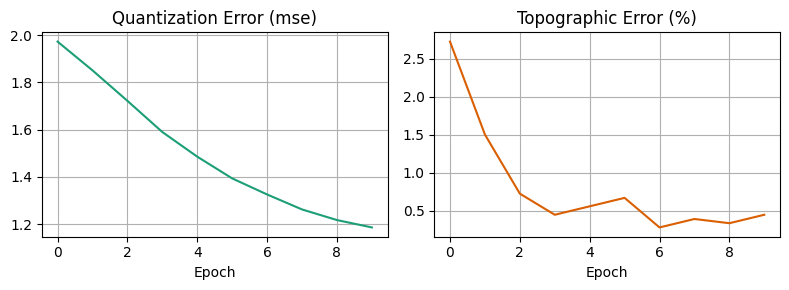

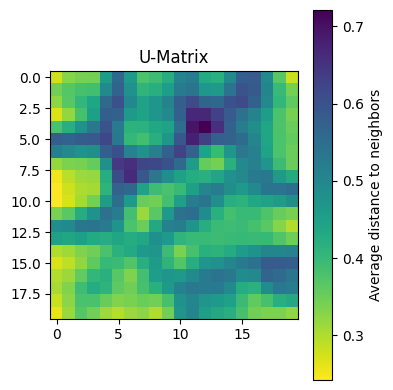

In [ ]:
#| eval: false
# Load and normalize MNIST data
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
X_norm = (X - np.mean(X, axis=-1, keepdims=True))/X.max()

# Create and train SOM
som = SOM(grid_sz=(20,20), input_dim=64, init='pca')
_ = som.fit(X_norm, n_epochs=10, verbose=True)
som.plot_umatrix(figsize=(4,4))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()